In [1]:
## final project 
import numpy as np 
import matplotlib.pyplot as plt 


## Miguel Alfonso Zapata De La Cruz 
## Proyecto final: Nested Sampling 
### Remember that the Bayes 
$$
P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}
$$
with $P(B|A)$ the likelihood, i.e. te probability of "B" being true given "A" is true, the prior $P(A)$ is the probability being true, i.e. the knowledge, the marginalization $P(B)$ and the posterior $P(A|B)$ i.e. the probability of "A" being true given "B" is true.  

For use de nested sampling algorithm, we are interested in integrate some target function (the likelihood times the prior) in some parameter space. 

In [2]:
# we start with choose the likelihood  
def log10_likelihood(*parameters):
   a = np.asarray(parameters)[:-1]*10
   b = np.asarray(parameters)[1:]*10 
   return -2*(100*(b-a**2)**2 + (1-a)**2).sum()

In [3]:
# we need to define the domain of ours parameters, we choose the following limits +
max, inf = -1, 1 
# the dimension is 
dim = 2 
# now, we generate the parameters 
n = 100
a = np.linspace(max,inf,n)
b = np.linspace(max,inf,n) 
# the grid parameters is 
grid = np.meshgrid(a, b)
# using this grid we can define the grid for the posterior 
grid_log_posterior = np.vectorize(log10_likelihood)(grid[0], grid[1])

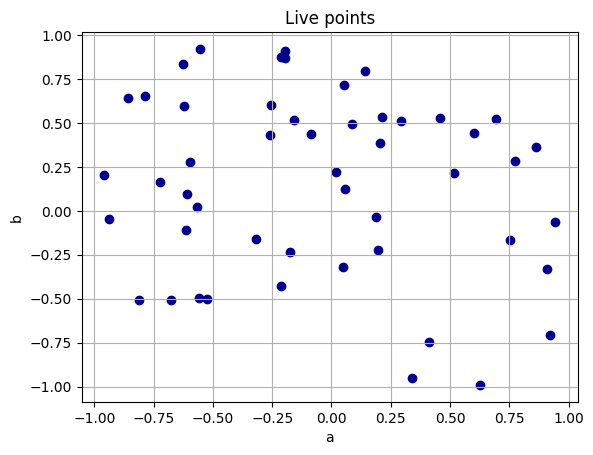

In [4]:
# we introduce the number of the live points 
N_live = 50
live_p = np.random.uniform(inf, max, size=(N_live,dim))
live_p_loglikelihood = np.vectorize(log10_likelihood)(*live_p.transpose())

plt.scatter(live_p[:,0], live_p[:,1],color='darkblue')
plt.title('Live points')
plt.xlabel('a')
plt.ylabel('b')
plt.grid()


In [5]:
# we sample the entire prior volumen equal to 1 
Vol = 1 
# we order the points with de likelihood 
points_order = np.argsort(live_p_loglikelihood)
points_order

# note that likelihood distribution of these points follows the distribution of likelihood values of points distributed according to the prior


array([ 4, 32, 27,  7, 43,  2, 33, 10,  3, 11, 20, 21, 42, 34, 14,  0, 16,
       24, 30, 22,  1, 28, 41, 39,  8, 13, 45, 47, 40, 48, 17, 15, 46,  5,
        6, 25, 36, 31, 29, 37, 35, 26,  9, 19, 23, 12, 18, 49, 44, 38])

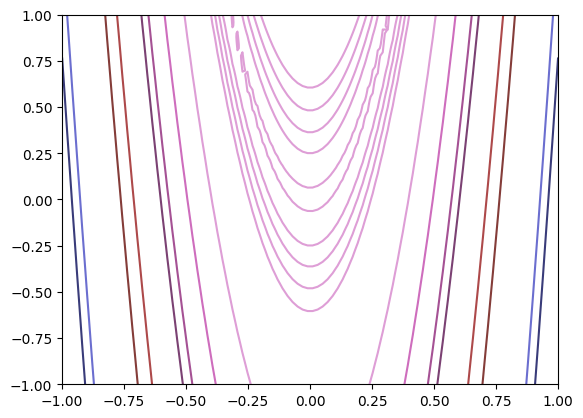

In [6]:
# The volumes enclosed between each likelihood interval is Beta(1, N) of the total volume.
#But in most cases we do not have the grid above, so we do not know the exact volume. So we need to approximate it.

plt.contour(a, b, grid_log_posterior, levels=live_p_loglikelihood[points_order[::4]], cmap='tab20b')

# Lets approximate with a random Beta(1, N)


In [7]:

volume_shell = np.random.beta(1, N_live)
volume_shell

# The volume remaining becomes smaller by 

Vol *= 1 - volume_shell

# Lets identify the worst point (lowest likelihood contour)
p_inf = np.argmin(live_p_loglikelihood)
L_worst = live_p_loglikelihood[p_inf]


Text(0, 0.5, 'b')

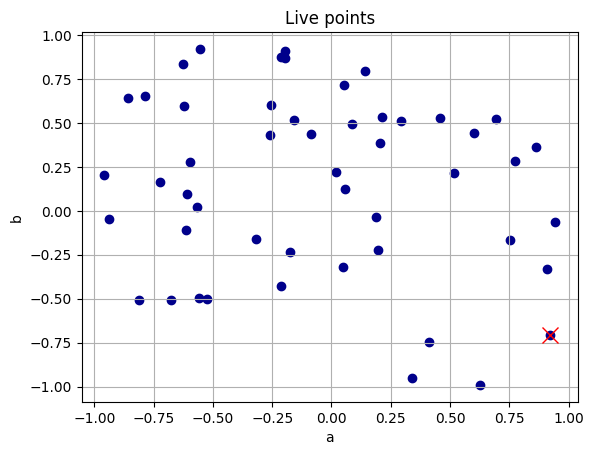

In [8]:
plt.scatter(live_p[:,0], live_p[:,1],color="darkblue",)
plt.plot(live_p[p_inf,0], live_p[p_inf,1],color='red',marker='x', ms=12)
plt.grid()
plt.title('Live points')
plt.xlabel('a')
plt.ylabel('b')

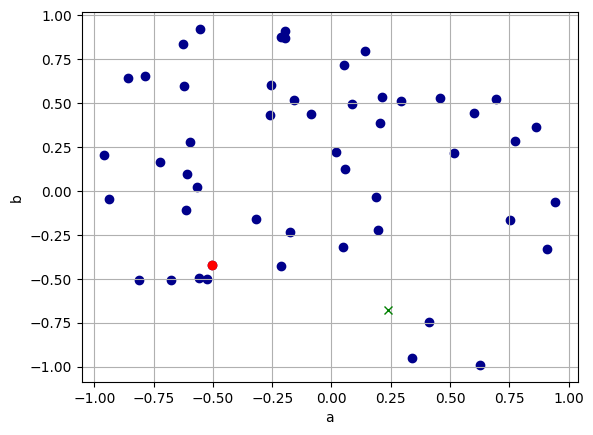

In [19]:
# we need to add the worst point to the dead points 
dead_p = [live_p[p_inf].copy()]
dead_po_loglikelihood = [L_worst]
dead_p_vol = volume_shell
# now we need to replace the worst point with a new point drawn sampled from the prior, with the condition that whose likelihood L_new > L_worst
# for this, we use the likelihood-restricted prior sampling method (LRPS), thus
def LRPS_rejection(Lmin):
    for i in range(10):
        proposed_points = np.random.uniform(inf, max, size=(1000, dim))
        proposed_p_loglikelihood = np.vectorize(log10_likelihood)(*proposed_points.transpose())
        if (proposed_p_loglikelihood > Lmin).any():
            i = np.where(proposed_p_loglikelihood > Lmin)[0][0]
            return proposed_points[i,:], proposed_p_loglikelihood[i]




live_p[p_inf], live_p_loglikelihood[p_inf] = LRPS_rejection(L_worst)
plt.scatter(live_p[:,0], live_p[:,1],color='darkblue',label='new live point')
plt.grid()
plt.xlabel('a')
plt.ylabel('b')
plt.plot(dead_p[0][0], dead_p[0][1], 'x',c='green')
plt.plot(live_p[p_inf,0], live_p[p_inf,1], 'o',c='red')


In [10]:
def nested_sampling(Niter, Nlive):
    volume = 1
    
    live_points = np.random.uniform(inf, max, size=(Nlive, dim))
    live_points_loglikelihood = np.vectorize(log10_likelihood)(*live_points.transpose())
    
    dead_points = []
    dead_points_loglikelihoods = []
    dead_points_volume = []
    volume_remaining = []
    
    for i in range(Niter):
        # find the current likelihood threshold
        Lmin = live_points_loglikelihood.min()
        lowest = np.argmin(live_points_loglikelihood)

        # shrink volume
        volume_shell_fraction = np.random.beta(1, Nlive)
        volume_shell = volume * volume_shell_fraction
        volume *= 1 - volume_shell_fraction

        # eject this point
        dead_points.append(live_points[lowest].copy())
        dead_points_loglikelihoods.append(np.copy(Lmin))
        dead_points_volume.append(volume_shell)
        volume_remaining.append(volume)

        # replace point if we can
        replacement = LRPS_rejection(Lmin)
        if replacement is None: break
        live_points[lowest], live_points_loglikelihood[lowest] = replacement
    
    return dead_points, dead_points_loglikelihoods, dead_points_volume, volume_remaining

Text(0, 0.5, 'Volume')

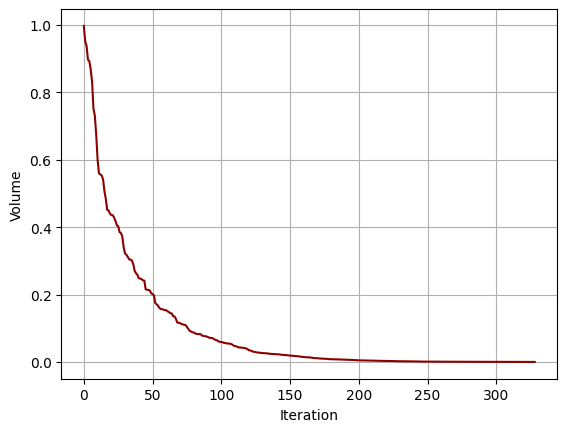

In [21]:
dead_points, dead_points_loglikelihoods, dead_points_volume, volume_remaining = nested_sampling(400, Nlive=40)
plt.plot(volume_remaining, color = 'darkred')
#plt.yscale('log')
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Volume")



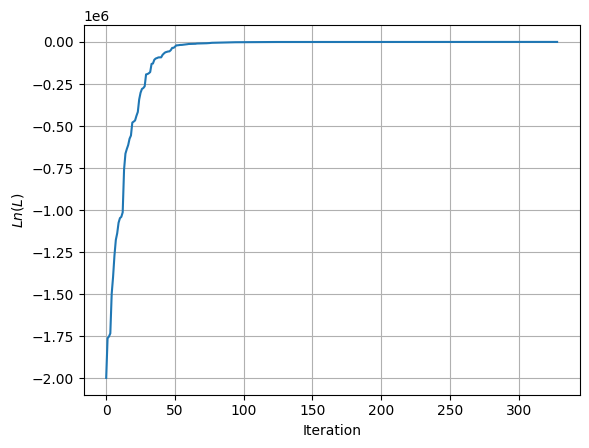

In [22]:
plt.plot(dead_points_loglikelihoods)
plt.xlabel("Iteration")
plt.ylabel("$Ln(L)$")
plt.grid()

Text(0.5, 0, 'Volume enclosed')

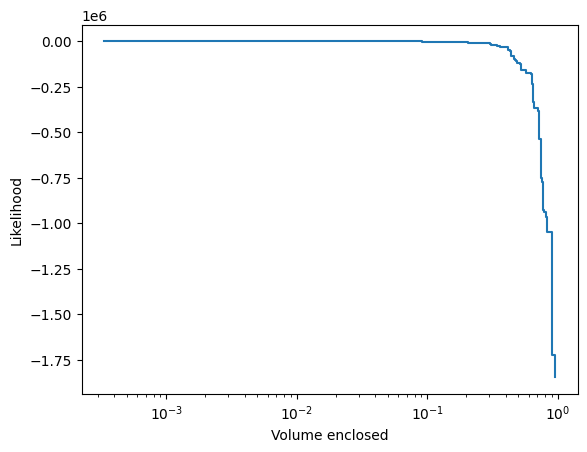

In [13]:
plt.plot(volume_remaining, dead_points_loglikelihoods, '-', drawstyle='steps-pre')
plt.xscale('log')
plt.ylabel("Likelihood")
plt.xlabel("Volume enclosed")

## for the evidence, we approach 
$$
z \simeq \sum_{i=1} \Delta V_i \times L_i 
$$

In [14]:
evidence = np.sum((dead_points_volume * np.exp(dead_points_loglikelihoods)))
print("Bayesian evidence: %f" % evidence)

Bayesian evidence: 0.000269


### and the normalised weight of each dead point

$w_i = \Delta V_i \times L_i$

### This gives us weighted posterior samples

Text(0, 0.5, 'Dead point importance weight')

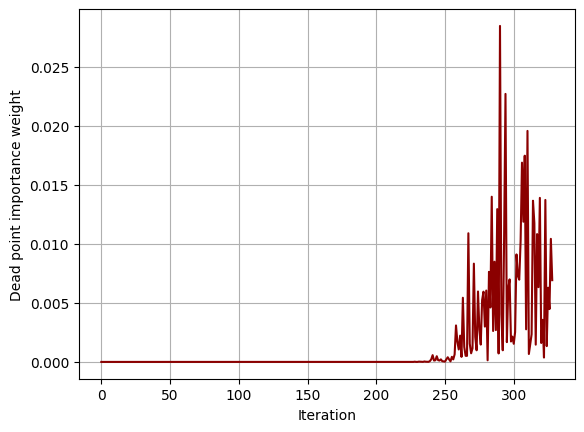

In [23]:
dead_points_weight = dead_points_volume * np.exp(dead_points_loglikelihoods) / evidence
plt.plot(dead_points_weight,color='darkred')
plt.xlabel("Iteration")
plt.grid()

plt.ylabel("Dead point importance weight")



In [16]:
def effective_sample_size(importance_weights):
    return int(len(importance_weights) / (1 + (importance_weights / importance_weights.mean() - 1)**2).mean() )

'Effective number of samples: %d' % effective_sample_size(dead_points_weight)


'Effective number of samples: 45'

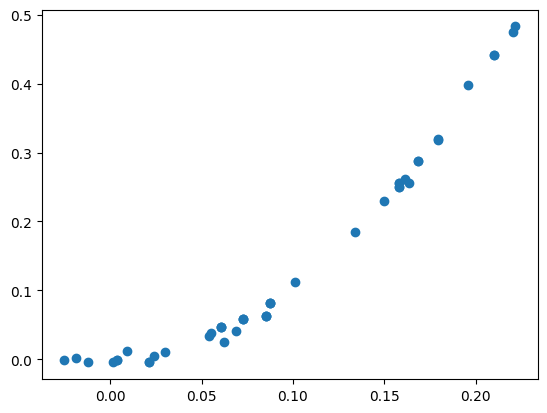

In [17]:
## Lets again get unweighted (equally weighted) posterior samples by resampling with repetition 
indices_chosen = np.random.choice(len(dead_points_weight), p=dead_points_weight, size=effective_sample_size(dead_points_weight))
posterior_samples = np.asarray(dead_points)[indices_chosen]
plt.scatter(posterior_samples[:,0], posterior_samples[:,1])